In [46]:
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

### Workflow:

1. Problem setup and baselining
2. Feature engineering to improve our model
3. Preliminary results

In [47]:
path = 'data/archive (2)/'
df_train = pd.read_csv(path+'train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Employment Duration           67463 non-null  object 
 10  Home Ownership                67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

In [48]:
#df_test_X = pd.read_csv(path+'test.csv')
#df_test_y = pd.read_csv(path+'submission.csv') (not good data set)

### 1. Check if it is an imbalanced classification task

In [49]:
target_pcts = df_train['Loan Status'].value_counts(normalize = True)
print(target_pcts)

0    0.90749
1    0.09251
Name: Loan Status, dtype: float64


<AxesSubplot:>

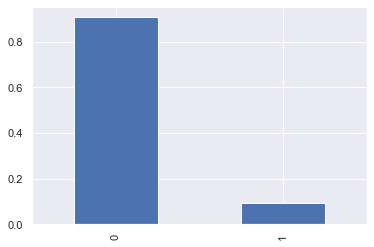

In [50]:
target_pcts.plot(kind = 'bar')

In [51]:
#sns.pairplot(df_train[])

In [113]:
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df['ID'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['ID'].isin(test_users)]
    df_te = df[df['ID'].isin(test_users)] 

    y_tr, y_te = df_tr['Loan Status'], df_te['Loan Status']
    X_tr = df_tr.drop(['ID','Loan Status'],axis=1)
    X_te = df_te.drop(['ID','Loan Status'],axis=1)

    return X_tr, X_te, y_tr, y_te

In [262]:

The_X = pd.get_dummies(df_train.drop(['Loan Status','Term','Batch Enrolled','Sub Grade','Payment Plan','Collection 12 months Medical','Application Type','Accounts Delinquent'],axis=1),drop_first=True)
#The_X = df_train[['ID','Debit to Income','Public Record','Total Accounts','Total Current Balance']]
The_X['Loan Status'] = df_train[['Loan Status']]

In [263]:
X_tr, X_te, y_tr, y_te = get_user_split_data(The_X)

In [264]:
X_te.head()

,Loan Amount,Funded Amount,Funded Amount Investor,Interest Rate,Home Ownership,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,...,Loan Title_get out of debt,Loan Title_home improvement,Loan Title_loan1,Loan Title_pay off bills,Loan Title_payoff,Loan Title_personal,Loan Title_refi,Loan Title_relief,Loan Title_vacation,Initial List Status_w
4,16890,13226,13539.926670,15.008300,44234.82545,17.209886,1,3,13,1,...,0,0,0,0,0,0,0,0,0,1
6,30844,19773,15777.511830,10.731432,102391.82430,15.083911,0,0,11,0,...,0,0,0,0,0,0,0,0,0,1
7,20744,10609,7645.014802,13.993688,61723.52014,29.829715,0,0,14,0,...,0,0,0,0,0,0,0,0,0,1
34,14429,20500,8733.240371,6.337292,47963.58195,33.535387,0,0,12,0,...,0,0,0,0,0,0,0,0,0,0
35,15257,6911,3801.222520,16.942665,84580.15874,22.141146,0,0,9,0,...,0,0,0,0,0,0,0,0,0,1


#### Oversampling

In [265]:
import imblearn.over_sampling
from sklearn.metrics import f1_score, roc_auc_score
# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 4, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_resample(X_tr, y_tr)

lr = LogisticRegression(solver='liblinear') 
lr.fit(X_tr, y_tr)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr.predict(X_te)), roc_auc_score(y_te, lr.predict_proba(X_te)[:,1]))) 

lr_os = LogisticRegression(solver='liblinear') 
lr_os.fit(X_tr_rs, y_tr_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr_os.predict(X_te)), roc_auc_score(y_te, lr_os.predict_proba(X_te)[:,1])))


Simple Logistic Regression; Test F1: 0.000, Test AUC: 0.499
Logistic Regression on Oversampled Train Data; Test F1: 0.000, Test AUC: 0.497


### Soft prediction

In [277]:
thres = 0.35
y_pred = (lr.predict_proba(X_te)[:,1]>thres)
print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, y_pred), roc_auc_score(y_te, lr.predict_proba(X_te)[:,1]))) 

y_predos = (lr_os.predict_proba(X_te)[:,1]>thres)
print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, y_predos), roc_auc_score(y_te, lr_os.predict_proba(X_te)[:,1])))


Simple Logistic Regression; Test F1: 0.000, Test AUC: 0.499
Logistic Regression on Oversampled Train Data; Test F1: 0.104, Test AUC: 0.497


### Confusion Matrix

In [278]:
def make_confusion_matrix(model, threshold=thres):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_te)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_te, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Non-defaulter', 'defaulter'],
           yticklabels=['Non-defaulter', 'defaulter']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

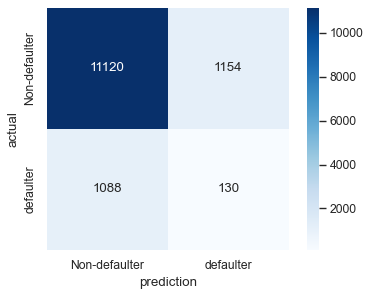

In [279]:
from sklearn.metrics import confusion_matrix
make_confusion_matrix(lr_os)

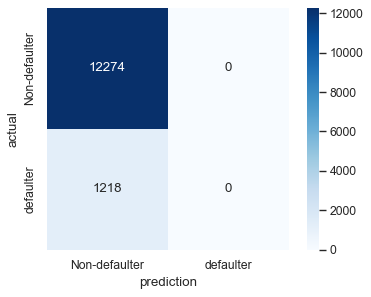

In [280]:
make_confusion_matrix(lr)

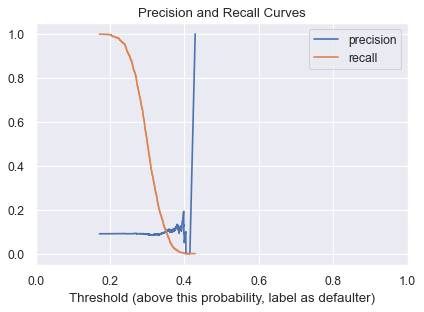

In [281]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, lr_os.predict_proba(X_te)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold (above this probability, label as defaulter)');
plt.xlim([0,1]);
plt.title('Precision and Recall Curves');

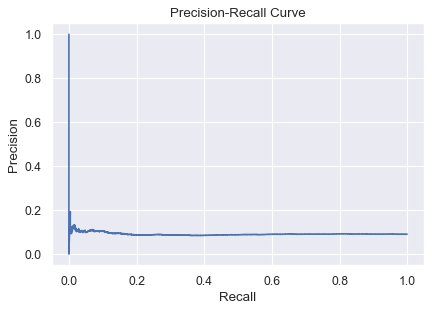

In [282]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

### Plot ROC using Oversampled data

ROC AUC score =  0.49689713501218613


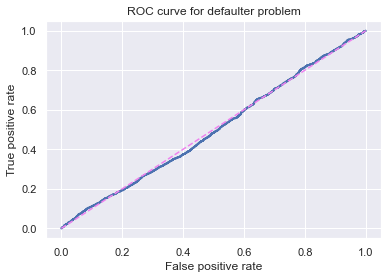

In [283]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_te, lr_os.predict_proba(X_te)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for defaulter problem');
print("ROC AUC score = ", roc_auc_score(y_te, lr_os.predict_proba(X_te)[:,1]))

### Plot ROC using not Oversampled data

ROC AUC score =  0.4987080035949808


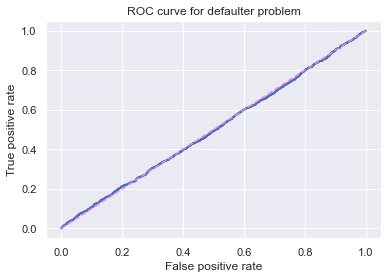

In [284]:
fpr, tpr, thresholds = roc_curve(y_te, lr.predict_proba(X_te)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for defaulter problem');
print("ROC AUC score = ", roc_auc_score(y_te, lr.predict_proba(X_te)[:,1]))